In [50]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 
from tqdm import tqdm
import tqdm.notebook as tq
import optuna

trainset = dsets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
BATCH_SIZE = 256
LEARNING_RATE = 3e-3

Reading CIFAR10 Dataset

In [ ]:
train_data_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [ ]:
test_data_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=1,
                                          shuffle=True)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Moving to Cuda

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# defining model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=256, output_dim=10):
        super().__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )
    
    def forward(self, x):
        x_flat = x.view(-1, self.input_dim)
        out = self.model(x_flat)
        return out


In [ ]:
def train(N_EPOCHS, model, optimizer, criterion):
    loss_hist  = []

    for epoch in range(N_EPOCHS):
        loss_list = []
        progress_bar = tqdm(enumerate(train_data_loader), total=len(train_data_loader))
        for i, (imgs, labels) in progress_bar:
        
            #everything needs to be on the same device
            imgs = imgs.to(device)
            labels = labels.to(device)
        
            # forward pass
            pred_labels = model(imgs)
    
            # computing error
            loss = criterion(pred_labels, labels)
            loss_list.append(loss.item())

            # removing accumulated gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if(i % 1 == 0 or i == N_ITERS-1):
                progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
            
        loss_hist.append(np.mean(loss_list))# loss and optimizer
    return loss_hist

In [ ]:
# instanciating model
model = LogisticRegressionModel()
model = model.to(device)

setting hyperparameters

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
lr = LEARNING_RATE
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
loss = train(10, model, optimizer, criterion)

Epoch 10 Iter 196: loss 1.64013. : 100%|██████████| 196/196 [00:07<00:00, 25.03it/s]


Plotting the Learning Curve

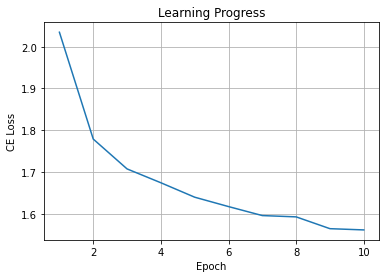

In [ ]:
loss_hist = loss
x = np.arange(1, len(loss_hist)+1)
plt.plot(x, loss_hist)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("CE Loss")
plt.title("Learning Progress")
plt.show()

Calculation of Accuracy

In [ ]:
def accuracy(model):
    n_correct = 0

    with torch.no_grad():
        progress_bar = tqdm(enumerate(test_data_loader), total=len(test_data_loader))
        for i, (imgs, labels) in progress_bar: 
            #everything needs to be on the same device
            imgs = imgs.to(device)
            labels = labels.to(device)
        
            # forward pass
            pred_labels = model(imgs)
        
            preds = torch.argmax(pred_labels, dim=-1)
            cur_correct = len(torch.where(preds == labels)[0])
            n_correct = n_correct + cur_correct

    accuracy = n_correct / len(testset) * 100
    print(f"Test accuracy: {round(accuracy,2)}%")
    return accuracy

Calculation of Confusion matrix

In [ ]:
def confusion_matrix(model):
    with torch.no_grad():
        confusion_mat = np.zeros((10, 10))
        progress_bar = tqdm(enumerate(test_data_loader), total=len(test_data_loader))
        for i, (imgs, labels) in progress_bar:
            imgs = imgs.to(device)
            labels = labels.to(device)
            pred_labels = model(imgs)
            preds = torch.argmax(pred_labels, dim=-1)
            confusion_mat[preds.numpy()[0]][labels.numpy()[0]] +=1
    return confusion_mat
        

In [ ]:
confusion_mat = confusion_matrix(model)

100%|██████████| 10000/10000 [00:03<00:00, 2867.51it/s]


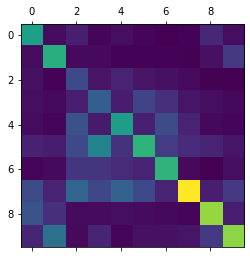

In [ ]:
plt.matshow(confusion_mat)
plt.show()

In [ ]:
def calc_precision(conf_mat):
    precision_class = np.zeros(10)
    for i in range(10):
        precision_class[i] = conf_mat[i][i]/np.sum(conf_mat[:,i])
    return(np.mean(precision_class))            

In [ ]:
def calc_recall(conf_mat):
    recall_class = np.zeros(10)
    for i in range(10):
        recall_class[i] = conf_mat[i][i]/(np.sum(conf_mat[i,:])+ 0.00001)
    return(np.mean(recall_class))   

In [ ]:
recall = calc_recall(confusion_mat)
precision = calc_precision(confusion_mat)


In [ ]:
print(recall, precision)

0.444389264985147 0.4286


trying different hyperparameters:

the original network was trained with BATCH_SIZE = 256 and LEARNING_RATE = 3e-3.
we try BATCH_SIZE = 128, 512 and LEARNING_RATE = 3e-1 , 3e-5.
This would give us 9 training models. Then, we will plot avaragee per-class precision and average per-class recall of models with respect to their hyper parameters.

In [ ]:
precisions = np.zeros((3,3), dtype=float)
recalls = np.zeros((3,3), dtype=float)

In [ ]:
precisions[1][1] = precision
recalls[1][1] = recall

100%|██████████| 10000/10000 [00:03<00:00, 2745.70it/s]

Test accuracy: 42.86%


MODEL 1:

In [ ]:
BATCH_SIZE = 256 
LEARNING_RATE = 3e-1

In [ ]:
model1 = LogisticRegressionModel()
model1 = model1.to(device)

In [ ]:
lr = LEARNING_RATE
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)

In [ ]:
train(10, model1, optimizer, criterion)

Epoch 10 Iter 196: loss 2.30166. : 100%|██████████| 196/196 [00:07<00:00, 26.62it/s]


[106.45242214567807,
 2.3197210041844114,
 2.309539432428321,
 2.3090630465624282,
 2.3103599742967256,
 2.31058108684968,
 2.3137712429980843,
 2.313237794807979,
 2.3119124429566518,
 2.311569243061299]

In [ ]:
conf_mat1 = confusion_matrix(model1)

100%|██████████| 10000/10000 [00:03<00:00, 2699.32it/s]


In [ ]:
precisions[1][0] = calc_precision(conf_mat1) 
recalls[1][0] = calc_recall(conf_mat1)

100%|██████████| 10000/10000 [00:04<00:00, 2304.97it/s]

Test accuracy: 10.0%


MODEL2

In [ ]:
BATCH_SIZE = 256 
LEARNING_RATE = 3e-5

In [ ]:
model2 = LogisticRegressionModel()
model2 = model2.to(device)

In [ ]:
lr = LEARNING_RATE
optimizer = torch.optim.Adam(model2.parameters(), lr=lr)

In [ ]:
train(10, model2, optimizer, criterion)

Epoch 10 Iter 196: loss 1.70215. : 100%|██████████| 196/196 [00:07<00:00, 25.00it/s]


[2.100915409472524,
 1.9341060367165779,
 1.8727627372255131,
 1.834288831268038,
 1.8052131916795457,
 1.781002360947278,
 1.7585191021160202,
 1.741516657021581,
 1.7225436294565395,
 1.709280099795789]

In [ ]:
conf_mat2 = confusion_matrix(model2)

100%|██████████| 10000/10000 [00:03<00:00, 2594.12it/s]


In [ ]:
precisions[1][2] = calc_precision(conf_mat2)
recalls[1][2] = calc_recall(conf_mat2)

100%|██████████| 10000/10000 [00:03<00:00, 2829.09it/s]

Test accuracy: 40.68%


MODEL3

In [ ]:
BATCH_SIZE = 128 
LEARNING_RATE = 3e-3

In [ ]:
train_data_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [ ]:
model3 = LogisticRegressionModel()
model3 = model3.to(device)

In [ ]:
lr = LEARNING_RATE
optimizer = torch.optim.Adam(model3.parameters(), lr=lr)

In [ ]:
train(10, model3, optimizer, criterion)

Epoch 10 Iter 391: loss 1.79150. : 100%|██████████| 391/391 [00:09<00:00, 39.42it/s]


[1.953550513748013,
 1.7639407324973884,
 1.718172530079132,
 1.6881035380351268,
 1.6676667913451524,
 1.6500503846141688,
 1.6368838170605242,
 1.6235169199726465,
 1.6210084153563165,
 1.5985867705796382]

In [ ]:
conf_mat3 = confusion_matrix(model3)

100%|██████████| 10000/10000 [00:03<00:00, 2907.46it/s]


In [ ]:
precisions[0][1] = calc_precision(conf_mat3) 
recalls[0][1] = calc_recall(conf_mat3)

100%|██████████| 10000/10000 [00:03<00:00, 2763.18it/s]

Test accuracy: 42.15%


MODEL4

In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 3e-1

In [ ]:
model4 = LogisticRegressionModel()
model4 = model4.to(device)

In [ ]:
lr = LEARNING_RATE
optimizer = torch.optim.Adam(model4.parameters(), lr=lr)

In [ ]:
train(10, model4, optimizer, criterion)

Epoch 10 Iter 391: loss 2.30591. : 100%|██████████| 391/391 [00:10<00:00, 36.11it/s]


[138.01901077065625,
 2.312179556892961,
 2.3177797568728553,
 2.31728605053309,
 2.318038028829238,
 2.3183285879052202,
 2.3187299762540463,
 2.318106125077933,
 2.317654774317046,
 2.3190483796931898]

In [ ]:
conf_mat4 = confusion_matrix(model4)

100%|██████████| 10000/10000 [00:03<00:00, 2882.89it/s]


In [ ]:
precisions[0][0] = calc_precision(conf_mat4) 
recalls[0][0] = calc_recall(conf_mat4)

100%|██████████| 10000/10000 [00:04<00:00, 2393.25it/s]

Test accuracy: 10.0%


MODEL5

In [ ]:
BATCH_SIZE = 128 
LEARNING_RATE = 3e-5

In [ ]:
model5 = LogisticRegressionModel()
model5 = model5.to(device)

In [ ]:
lr = LEARNING_RATE
optimizer = torch.optim.Adam(model5.parameters(), lr=lr)

In [ ]:
train(10, model5, optimizer, criterion)

Epoch 10 Iter 391: loss 1.63564. : 100%|██████████| 391/391 [00:07<00:00, 53.23it/s]


[2.060151630655274,
 1.8993837842551033,
 1.8396446095098316,
 1.8011146887488987,
 1.7681733064944176,
 1.7424155150533027,
 1.717562351690229,
 1.6945254918559434,
 1.6745282262182601,
 1.6568102641483706]

In [ ]:
conf_mat5 = confusion_matrix(model5)

100%|██████████| 10000/10000 [00:02<00:00, 3783.93it/s]


In [ ]:
accuracies[0][2] = accuracy(model5)
precisions[0][2] = calc_precision(conf_mat5) 
recalls[0][2] = calc_recall(conf_mat5)

100%|██████████| 10000/10000 [00:03<00:00, 2716.29it/s]

Test accuracy: 42.72%


MODEL6

In [ ]:
BATCH_SIZE = 512 
LEARNING_RATE = 3e-3

In [ ]:
train_data_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [ ]:
model6 = LogisticRegressionModel()
model6 = model6.to(device)

In [ ]:
lr = LEARNING_RATE
optimizer = torch.optim.Adam(model6.parameters(), lr=lr)

In [ ]:
train(10, model6, optimizer, criterion)

Epoch 10 Iter 98: loss 1.44394. : 100%|██████████| 98/98 [00:05<00:00, 19.12it/s]


[2.1648923815513146,
 1.8219211855713202,
 1.7361879214948537,
 1.6848850907111654,
 1.639162838459015,
 1.6127095575235328,
 1.5877989786011832,
 1.5743734933892075,
 1.5427648096668476,
 1.5350501525158784]

In [ ]:
conf_mat6 = confusion_matrix(model6)

100%|██████████| 10000/10000 [00:02<00:00, 4210.09it/s]


In [ ]:
precisions[2][1] = calc_precision(conf_mat6) 
recalls[2][1] = calc_recall(conf_mat6)

100%|██████████| 10000/10000 [00:03<00:00, 2782.30it/s]

Test accuracy: 44.61%


MODEL7

In [ ]:
BATCH_SIZE = 512
LEARNING_RATE = 3e-1

In [ ]:
model7 = LogisticRegressionModel()
model7 = model7.to(device)

In [ ]:
lr = LEARNING_RATE
optimizer = torch.optim.Adam(model7.parameters(), lr=lr)

In [ ]:
train(10, model7, optimizer, criterion)

Epoch 10 Iter 98: loss 2.30514. : 100%|██████████| 98/98 [00:05<00:00, 18.53it/s]


[324.0964646777328,
 2.3043176933210723,
 2.3053124121257236,
 2.305135814511046,
 2.30532329423087,
 2.306503271570011,
 2.307240858369944,
 2.306320713490856,
 2.3068529829687003,
 2.308076045951065]

In [ ]:
conf_mat7 = confusion_matrix(model7)

100%|██████████| 10000/10000 [00:03<00:00, 2768.23it/s]


In [ ]:
precisions[2][0] = calc_precision(conf_mat7) 
recalls[2][0] = calc_recall(conf_mat7)

100%|██████████| 10000/10000 [00:03<00:00, 2799.38it/s]

Test accuracy: 10.0%


MODEL8

In [ ]:
BATCH_SIZE = 512 
LEARNING_RATE = 3e-5

In [ ]:
model8 = LogisticRegressionModel()
model8 = model8.to(device)

In [ ]:
lr = LEARNING_RATE
optimizer = torch.optim.Adam(model8.parameters(), lr=lr)

In [ ]:
train(10, model8, optimizer, criterion)

Epoch 10 Iter 98: loss 1.70359. : 100%|██████████| 98/98 [00:05<00:00, 18.80it/s]


[2.1698629418197943,
 2.0083656529990996,
 1.93162403422959,
 1.886550958059272,
 1.855918756553105,
 1.8299743143879637,
 1.8082259309535125,
 1.78862557362537,
 1.7715087691131903,
 1.7559291051358592]

In [ ]:
conf_mat8 = confusion_matrix(model8)

100%|██████████| 10000/10000 [00:02<00:00, 4315.61it/s]


In [ ]:
precisions[2][2] = calc_precision(conf_mat8) 
recalls[2][2] = calc_recall(conf_mat8)

100%|██████████| 10000/10000 [00:03<00:00, 2801.57it/s]

Test accuracy: 39.21%


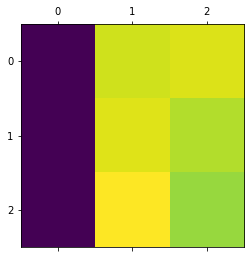

[[0.1    0.4215 0.4272]
 [0.1    0.4286 0.4068]
 [0.1    0.4461 0.3921]]


In [ ]:
plt.matshow(precisions)
plt.show()
print(precisions)

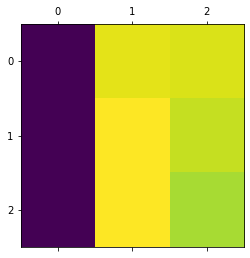

[[0.01       0.42748731 0.42097746]
 [0.010001   0.44438926 0.40608317]
 [0.01       0.44506672 0.38877025]]


In [ ]:
plt.matshow(recalls)
plt.show()
print(recalls)

The rows are showing the batches 128, 254, 512, and the columns are showing learning rate 3e-1, 3e-3, 3e-5.

In [51]:
def train_with_optimizer(N_EPOCHS, model, criterion, learning_rate=3e-3, batch_size=256, plot=False):
    
    print('Learning rate:', learning_rate, 'Batch size:', batch_size)
    train_data_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)
    
    test_data_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=batch_size,
                                          shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_hist  = []
    norm_hist = []
    for epoch in range(N_EPOCHS):
        loss_list = []
        progress_bar = tq.tqdm(enumerate(train_data_loader), total=len(train_data_loader), leave=True, position=0)
        for i, (imgs, labels) in progress_bar:
        
            #everything needs to be on the same device
            imgs = imgs.to(device)
            labels = labels.to(device)
        
            # forward pass
            pred_labels = model(imgs)
    
            # computing error
            loss = criterion(pred_labels, labels)
            loss_list.append(loss.item())

            # removing accumulated gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if(i % 1 == 0 or i == N_ITERS-1):
              progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
            
        loss_hist.append(np.mean(loss_list))# loss and optimizer
        norm_hist.append(model.model[2].weight.grad.data.norm())

        # print(accuracy(model))

    if plot:
      x = np.arange(1, len(norm_hist) + 1)
      plt.plot(x, norm_hist)
      plt.grid()
      plt.xlabel("x")
      plt.ylabel("Norm of the gradient of the last layer")
      plt.title("Norm of the gradients")
      plt.show()

    return accuracy(model)


In [52]:
model7 = LogisticRegressionModel()
model7 = model.to(device)

# Optimize learning rate and batch size
def objective(trial):

    batch_size = trial.suggest_int('batch_size', 4, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3)

    return train_with_optimizer(10, model7, criterion, learning_rate=learning_rate, batch_size=batch_size)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
best_learning_rate = study.best_params['learning_rate']
best_batch_size = study.best_params['batch_size']
print("Study best learning rate:", best_learning_rate)
print("Study best batch size:", best_batch_size)

[I 2021-05-23 20:09:46,398] A new study created in memory with name: no-name-f119b6fe-fda0-4427-857b-cb3341644b25


Learning rate: 0.0023287257619065693 Batch size: 27



  1%|▏         | 147/10000 [00:00<00:06, 1467.56it/s]


100%|██████████| 10000/10000 [00:06<00:00, 1625.14it/s]
[I 2021-05-23 20:16:28,028] Trial 0 finished with value: 45.23 and parameters: {'batch_size': 27, 'learning_rate': 0.0023287257619065693}. Best is trial 0 with value: 45.23.


Test accuracy: 45.23%
Learning rate: 0.0014275379788703994 Batch size: 295



  1%|▏         | 138/10000 [00:00<00:07, 1375.97it/s]


100%|██████████| 10000/10000 [00:06<00:00, 1605.37it/s]
[I 2021-05-23 20:18:29,240] Trial 1 finished with value: 47.21 and parameters: {'batch_size': 295, 'learning_rate': 0.0014275379788703994}. Best is trial 1 with value: 47.21.


Test accuracy: 47.21%
Learning rate: 0.003982743571908388 Batch size: 230



  2%|▏         | 154/10000 [00:00<00:06, 1530.92it/s]


100%|██████████| 10000/10000 [00:06<00:00, 1584.28it/s]
[I 2021-05-23 20:20:43,718] Trial 2 finished with value: 46.48 and parameters: {'batch_size': 230, 'learning_rate': 0.003982743571908388}. Best is trial 1 with value: 47.21.


Test accuracy: 46.48%
Learning rate: 0.001321729508768297 Batch size: 394


Epoch 4 Iter 104: loss 1.03566. :  48%|████▊     | 104/216 [13:00<14:00,  7.50s/it]



  1%|▏         | 125/10000 [00:00<00:07, 1246.60it/s]


100%|██████████| 10000/10000 [00:06<00:00, 1567.40it/s]
[I 2021-05-23 20:22:36,723] Trial 3 finished with value: 46.45 and parameters: {'batch_size': 394, 'learning_rate': 0.001321729508768297}. Best is trial 1 with value: 47.21.


Test accuracy: 46.45%
Learning rate: 0.0006986893728336638 Batch size: 281



  2%|▏         | 150/10000 [00:00<00:06, 1496.43it/s]


100%|██████████| 10000/10000 [00:06<00:00, 1523.27it/s]
[I 2021-05-23 20:24:45,262] Trial 4 finished with value: 46.7 and parameters: {'batch_size': 281, 'learning_rate': 0.0006986893728336638}. Best is trial 1 with value: 47.21.


Test accuracy: 46.7%
Study best learning rate: 0.0014275379788703994
Study best batch size: 295


Learning rate: 0.0014275379788703994 Batch size: 295


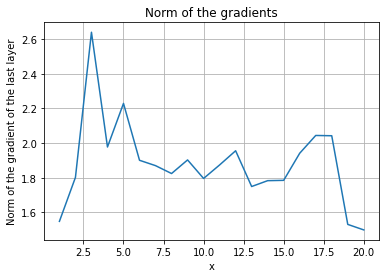


100%|██████████| 10000/10000 [00:06<00:00, 1606.96it/s]


Test accuracy: 46.01%


46.01

In [55]:
train_with_optimizer(20, model7, criterion, learning_rate=best_learning_rate, batch_size=best_batch_size, plot=True)